#### Funciones

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks

#Función para limpiar los datos
def limpiarDatos(lista):
  """
  Función datosLimpios()
  -Input: lista
  -Output: lista

  Cumple la función de limpiar listas de datos de datos no numéricos mediante math.isfinite()
  Retorna la misma lista ingresada sin datos "Nan"
  """
  datosLimpios = []
  for datos in lista:
    if math.isfinite(datos):
      datosLimpios.append(datos)
  return datosLimpios

def procesar_linea(elementos, tiempo, frecuencia, incertezas):
  """
  Procesa una línea del archivo.
  """
  datosLinea = elementos.split()

  # Verificar si la línea no está vacía
  if not datosLinea:
      print(f"Advertencia: línea vacía ignorada.")
      return tiempo, frecuencia, incertezas

  if len(datosLinea) == 3:
      try:
          tiempo.append(float(datosLinea[0]))
          frecuencia.append(float(datosLinea[1]))
          incertezas.append(float(datosLinea[2]))
      except ValueError:
          print(f"Advertencia: no se pudo convertir los valores a float en la línea: {elementos}")

  elif len(datosLinea) == 2:
      try:
          tiempo.append(float(datosLinea[0]))
          frecuencia.append(float(datosLinea[1]))
      except ValueError:
          print(f"Advertencia: no se pudo convertir los valores a float en la línea: {elementos}")
          
  else:
      print(f"Advertencia: número de columnas inesperadas en la línea: {elementos}")

  return tiempo, frecuencia, incertezas


def leerArchivo(archivo):
    """
    Función leerArchivo()
    -Input: archivo
    -Output: 3 listas

    Lee el archivo y procesa sus datos en 3 listas: tiempos, frecuencias, e incertezas.
    """
    with open(archivo, "r") as lectura:
        listaDatos = lectura.readlines()

    tiempo = []
    frecuencia = []
    incertezas = []

    # Procesar cada línea del archivo
    for elementos in listaDatos:
        tiempo, frecuencia, incertezas = procesar_linea(elementos, tiempo, frecuencia, incertezas)

    # Limpiar los datos de posibles Nans
    tiempoTrue = limpiarDatos(tiempo)
    frecuenciaTrue = limpiarDatos(frecuencia)
    
    # Si hay incertezas, limpiarlas también
    if incertezas:

        incertezasTrue = limpiarDatos(incertezas)
        return tiempoTrue, frecuenciaTrue, incertezasTrue

    else:
        return tiempoTrue, frecuenciaTrue, []

def ajuste_residuos_parabola(tiempo, frecuencia):
    """
    Ajusta una parábola a los datos de tiempo y frecuencia, y calcula los residuos.

    Parámetros:
    - tiempo: array de valores de tiempo.
    - frecuencia: array de valores de frecuencia.

    Retorna:
    - residuos: array de residuos (diferencia entre los datos y la tendencia ajustada).
    - linea_tendencia: array de valores de la parábola ajustada (tendencia).
    - coeficientes: coeficientes de la parábola ajustada [a0, a1, a2].
    """
    # Convertir las listas de entrada en arrays de numpy (en caso de que no lo sean)
    arrayTiempo = np.array(tiempo)
    arrayFrecuencia = np.array(frecuencia)

    # Calcular los términos necesarios para el sistema de ecuaciones
    n = len(arrayTiempo)
    x = np.sum(arrayTiempo)
    x2 = np.sum(arrayTiempo ** 2)
    x3 = np.sum(arrayTiempo ** 3)
    x4 = np.sum(arrayTiempo ** 4)
    y = np.sum(arrayFrecuencia)
    y2 = np.sum(arrayFrecuencia ** 2)
    y3 = np.sum(arrayFrecuencia ** 3)
    xy = np.sum(arrayTiempo * arrayFrecuencia)
    x2y = np.sum((arrayTiempo ** 2) * arrayFrecuencia)

    # Crear la matriz del sistema de ecuaciones
    matriz = np.array([[n, x, x2], [x, x2, x3], [x2, x3, x4]])
    array = np.array([y, xy, x2y])

    # Resolver el sistema de ecuaciones lineales
    coeficientes = np.linalg.solve(matriz, array)

    # Desglosar los coeficientes de la parábola
    a0 = coeficientes[0]
    a1 = coeficientes[1]
    a2 = coeficientes[2]

    # Ecuación de la parábola ajustada
    linea_tendencia = a0 + a1 * arrayTiempo + a2 * (arrayTiempo ** 2)

    # Calcular los residuos (diferencia entre los datos reales y la tendencia ajustada)
    residuo = arrayFrecuencia - linea_tendencia

    return residuo, coeficientes

def ajuste_residuos_lineal(tiempo, frecuencia):
    """
    Ajusta una línea recta a los datos de tiempo y frecuencia, y calcula los residuos.

    Parámetros:
    - tiempo: array de valores de tiempo.
    - frecuencia: array de valores de frecuencia.

    Retorna:
    - residuos: array de residuos (diferencia entre los datos y la tendencia ajustada).
    - linea_tendencia: array de valores de la recta ajustada (tendencia).
    - m, b: coeficientes de la recta ajustada (pendiente y el intercepto).
    """
    # Convertir las listas de entrada en arrays de numpy (en caso de que no lo sean)
    arrayTiempo = np.array(tiempo)
    arrayFrecuencia = np.array(frecuencia)

    # Calcular las sumas necesarias para el sistema de ecuaciones
    x = np.sum(arrayTiempo)
    y = np.sum(arrayFrecuencia)
    xy = np.sum(arrayFrecuencia * arrayTiempo)
    x2 = np.sum(arrayTiempo ** 2)

    # Calcular la pendiente m y el intercepto b usando las fórmulas del ajuste lineal
    m = (len(tiempo) * xy - x * y) / (len(tiempo) * x2 - x ** 2)
    b = (y * x2 - x * xy) / (len(tiempo) * x2 - x ** 2)

    # Ecuación de la recta ajustada
    linea_tendencia = m * arrayTiempo + b

    # Calcular los residuos (diferencia entre los datos reales y la tendencia ajustada)
    residuos = arrayFrecuencia - linea_tendencia

    return residuos, m, b

def detectar_picos(datos, paso):
    """
    Detecta los picos en los datos dados, con una distancia mínima entre picos especificada.
    
    :param datos: Lista o array de datos en los que se detectan los picos.
    :param paso: Mínima distancia entre picos consecutivos.
    :return: índices de los picos encontrados.
    """
    peaksDatos = find_peaks(datos, height=0, distance=paso)
    return peaksDatos[0]  # Retorna solo los índices de los picos

def obtener_glitches_y_tiempos(datos_glitches, paso, array_tiempos):
    """
    Obtiene los glitches y los tiempos aproximados en los que ocurren usando la detección de picos.
    
    :param datos_glitches: Lista o array de valores de glitches.
    :param tiempos: Lista o array de tiempos correspondientes a los glitches.
    :param paso: Mínima distancia entre picos consecutivos.
    :param array_tiempos: Lista o array con los tiempos globales para buscar los picos.

    
    :return: glitches detectados, tiempos de glitches calculados, índices de picos.
    """
    # Detectar los picos en los datos de glitches
    indices_peaks = detectar_picos(datos_glitches, paso)
    
    # Obtener los valores de glitches en los picos
    glitches = np.array([datos_glitches[i] for i in indices_peaks])

    # Obtener los tiempos correspondientes a los picos
    tiempos_glitches = np.array([array_tiempos[i] for i in indices_peaks])

    # Calcular los tiempos aproximados de los glitches (promedio entre picos consecutivos)
    tiempos_glitches_mjd = []

    # Calcular el promedio de los tiempos entre picos consecutivos
    for i in range(1, len(array_tiempos)):
        for j in range(len(indices_peaks)):
            if (array_tiempos[i] == tiempos_glitches[j]) & (array_tiempos[i-1] != tiempos_glitches[j]):
                # Promedio entre el tiempo del pico actual y el anterior
                tiempo = (tiempos_glitches[j] + array_tiempos[i-1]) / 2
                tiempos_glitches_mjd.append(tiempo)

    return glitches, tiempos_glitches_mjd, indices_peaks

In [23]:
tiempoB0531, frecuenciaB0531, incertezaB0531 = leerArchivo("./frec_B0531.dat")
tiempoB0833, frecuenciaB0833, incertezaB0531 = leerArchivo("./frec_B0833 (1).dat")
tiempoJ0537, frecuenciaJ0537, incertezaJ0537 = leerArchivo("./frec_J0537.dat")
tiempoJ1819, frecuenciaJ1819, incertezaJ1819 = leerArchivo("./frec_J1819.dat")

Advertencia: línea vacía ignorada.


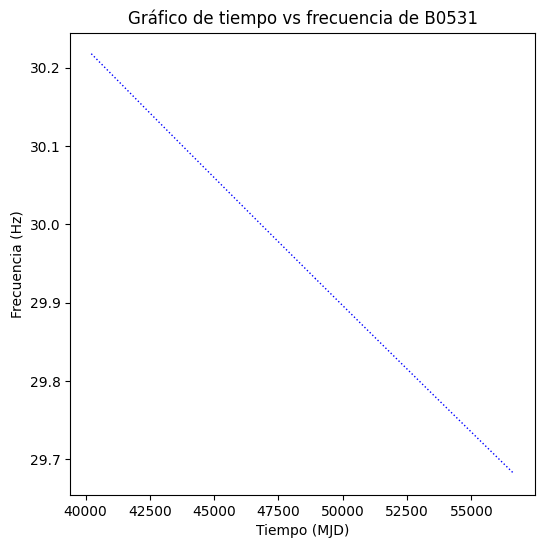

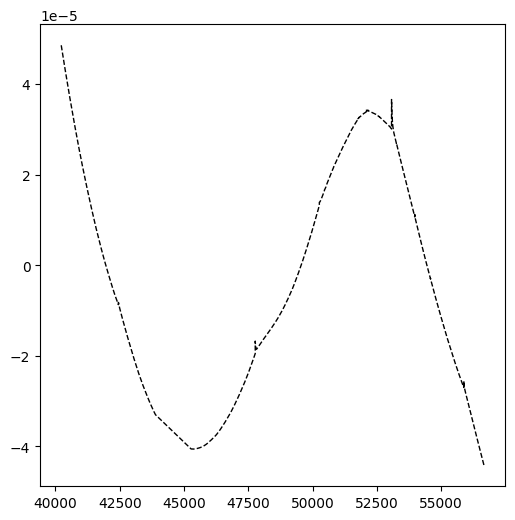

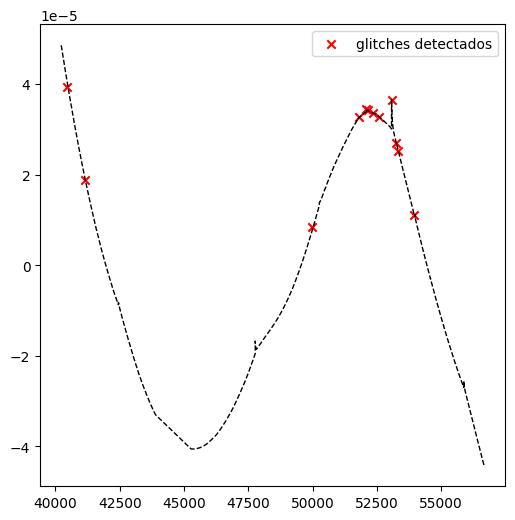

In [26]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0531,frecuenciaB0531,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

#calcular residuo:
residuoB0531, coeficientesB0531 = ajuste_residuos_parabola(tiempoB0531,frecuenciaB0531)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoB0531,residuoB0531,linewidth=1,color="black",linestyle="--")
plt.show()

#calculo glotches
glitches, tiempos_glitches_mjd, indices_peaks = obtener_glitches_y_tiempos(residuoB0531, 5, tiempoB0531)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoB0531,residuoB0531,linewidth=1,color="black",linestyle="--")
ax.scatter(tiempos_glitches_mjd, glitches, color='red', marker='x', label="glitches detectados")
plt.legend()
plt.show()



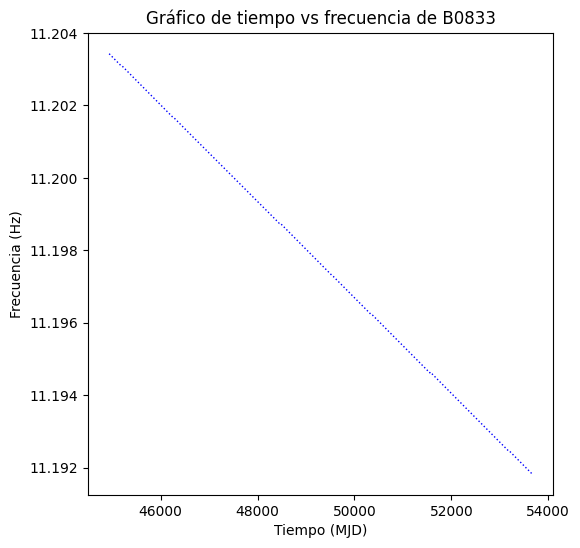

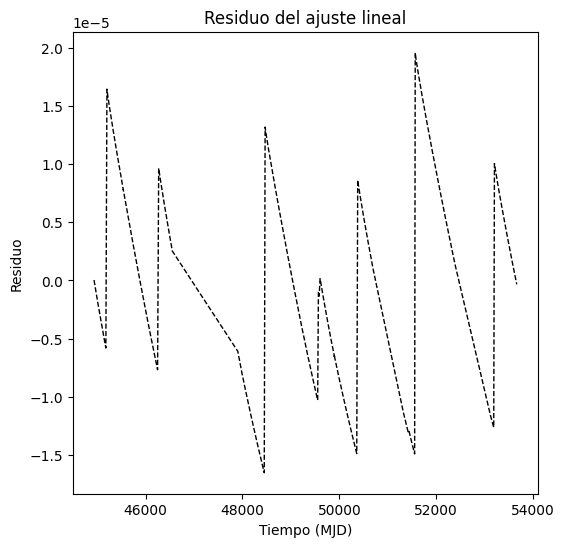

Largo t glitches: 10 Largo glitches 10
18 0 45201.819563 45179.729983 [np.float64(45190.774773)]
51 1 45432.924613 45395.430471 [np.float64(45190.774773), np.float64(45414.177542000005)]
71 1 45432.924613 45539.490473 [np.float64(45190.774773), np.float64(45414.177542000005), np.float64(45486.207543)]
207 2 46270.021916 46247.614326 [np.float64(45190.774773), np.float64(45414.177542000005), np.float64(45486.207543), np.float64(46258.818121000004)]
361 3 48467.438944 48449.695252 [np.float64(45190.774773), np.float64(45414.177542000005), np.float64(45486.207543), np.float64(46258.818121000004), np.float64(48458.567098)]
401 4 48690.463857 48710.619282 [np.float64(45190.774773), np.float64(45414.177542000005), np.float64(45486.207543), np.float64(46258.818121000004), np.float64(48458.567098), np.float64(48700.5415695)]
575 5 49602.409678 49583.264196 [np.float64(45190.774773), np.float64(45414.177542000005), np.float64(45486.207543), np.float64(46258.818121000004), np.float64(48458.56709

ValueError: x and y must be the same size

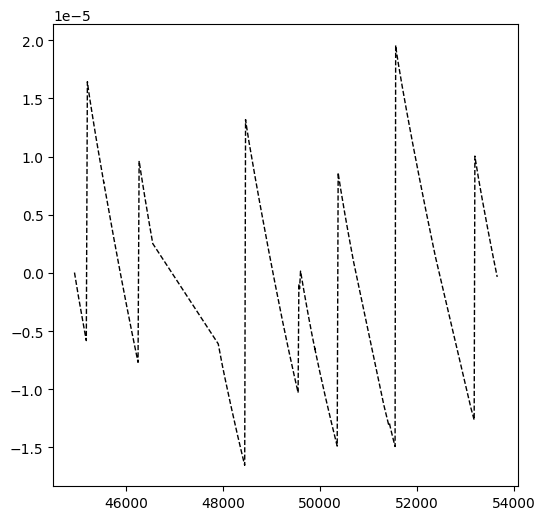

In [31]:
# tiempoB0833, frecuenciaB0833, incertezaB0531 

# Gráfico de tiempo vs frecuencia de B0833
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(tiempoB0833, frecuenciaB0833, color="blue", linewidth=1, linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0833")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")
plt.show()

# Calcular residuo:
residuoB0833, m, b = ajuste_residuos_lineal(tiempoB0833, frecuenciaB0833)

# Gráfico de residuos:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(tiempoB0833, residuoB0833, linewidth=1, color="black", linestyle="--")
ax.set_title("Residuo del ajuste lineal")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Residuo")
plt.show()

# Cálculo de glitches:
glitches, tiempos_glitches_mjd, indices_peaks = obtener_glitches_y_tiempos(residuoB0833, 1, tiempoB0833)

# Gráfico de residuos con glitches detectados:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.plot(tiempoB0833, residuoB0833, linewidth=1, color="black", linestyle="--")

# Verificar el funcionamiento de la función para ésta sección de código
peak_val = detectar_picos(residuoB0833,5)

glish = np.array([residuoB0833[i] for i in indices_peaks])
t_glish = np.array([tiempoB0833[i] for i in indices_peaks])
print("Largo t glitches:",len(t_glish),"Largo glitches",len(glish))

t_glish_mjd = []

# Calcular el promedio de los tiempos entre picos consecutivos
for i in range(1, len(tiempoB0833)):
    for j in range(len(peak_val)):
        if (tiempoB0833[i] == t_glish[j]) & (tiempoB0833[i-1] != t_glish[j]):
            # Promedio entre el tiempo del pico actual y el anterior
            tiempo = (t_glish[j] + tiempoB0833[i-1]) / 2
            t_glish_mjd.append(tiempo)
            print(i,j,t_glish[j],tiempoB0833[i-1],t_glish_mjd)

print("Largo t glitches mjd:",len(t_glish_mjd))

ax.scatter(tiempos_glitches_mjd, glitches, color='red', marker='x', label="glitches detectados")
ax.set_title("Glitches detectados en los residuos")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Residuo")
plt.legend()
plt.show()


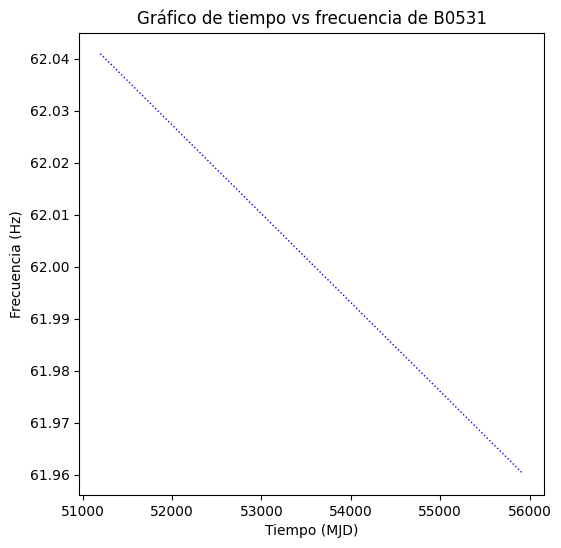

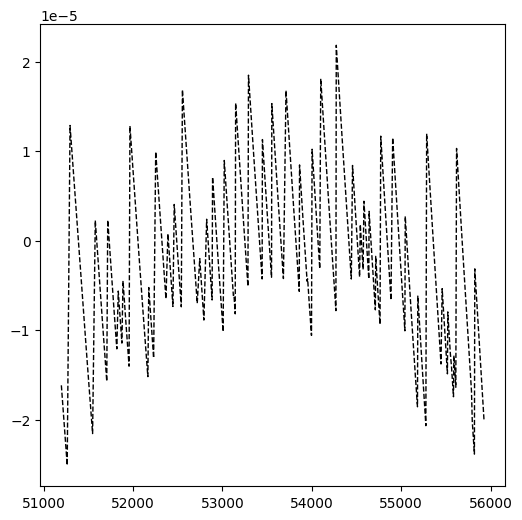

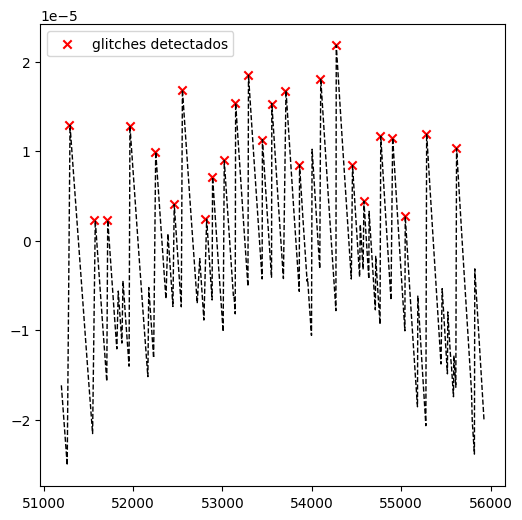

In [56]:
#tiempoJ0537, frecuenciaJ0537, incertezaJ0537
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ0537,frecuenciaJ0537,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

#calcular residuo:
residuoJ0537, m, b = ajuste_residuos_lineal(tiempoJ0537,frecuenciaJ0537)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoJ0537,residuoJ0537,linewidth=1,color="black",linestyle="--")
plt.show()

#calculo glotches
glitches, tiempos_glitches_mjd, indices_peaks = obtener_glitches_y_tiempos(residuoJ0537, 5, tiempoJ0537)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoJ0537,residuoJ0537,linewidth=1,color="black",linestyle="--")
ax.scatter(tiempos_glitches_mjd, glitches, color='red', marker='x', label="glitches detectados")
plt.legend()
plt.show()





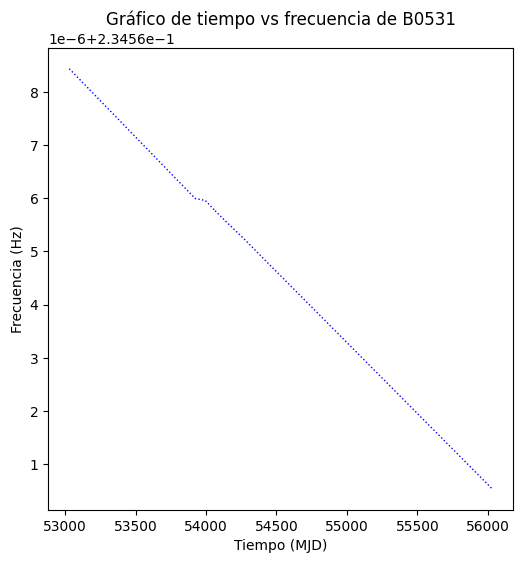

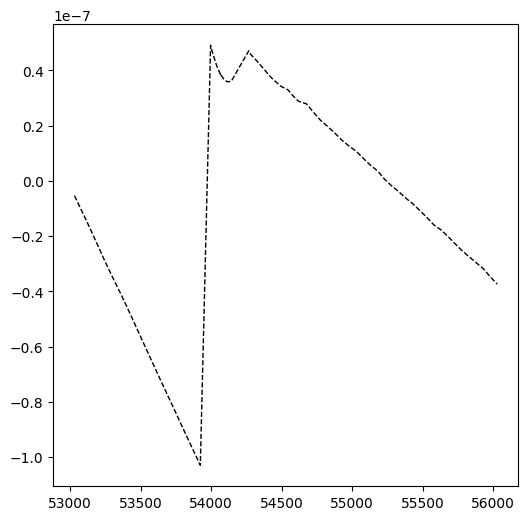

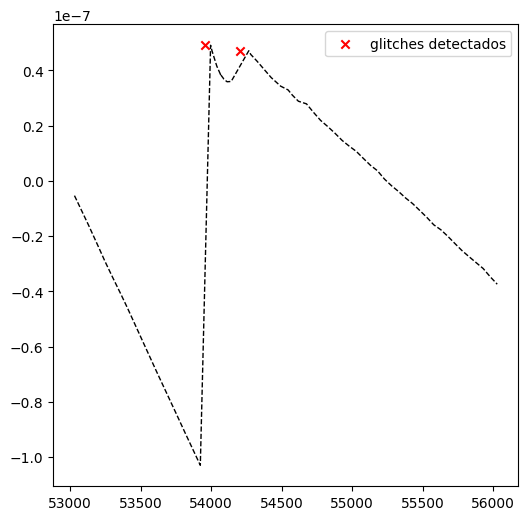

In [49]:
#tiempoJ1819, frecuenciaJ1819, incertezaJ1819
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ1819,frecuenciaJ1819,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

#calcular residuo:
residuoJ1819, m, b = ajuste_residuos_lineal(tiempoJ1819,frecuenciaJ1819)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoJ1819,residuoJ1819,linewidth=1,color="black",linestyle="--")
plt.show()

#calculo glotches
glitches, tiempos_glitches_mjd, indices_peaks = obtener_glitches_y_tiempos(residuoJ1819, 5, tiempoJ1819)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(tiempoJ1819,residuoJ1819,linewidth=1,color="black",linestyle="--")
ax.scatter(tiempos_glitches_mjd, glitches, color='red', marker='x', label="glitches detectados")
plt.legend()
plt.show()




Shape of A: (3, 3)
Shape of b: (3,)


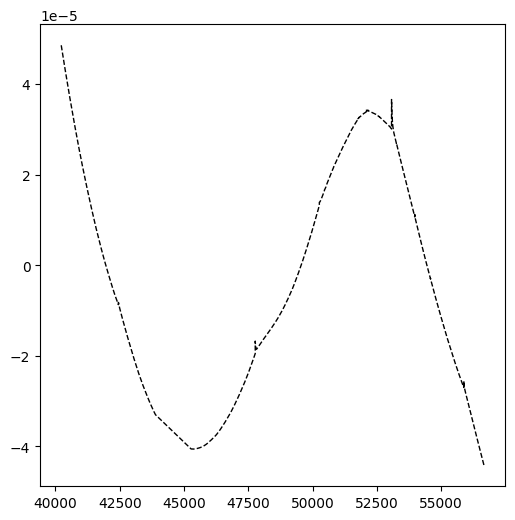

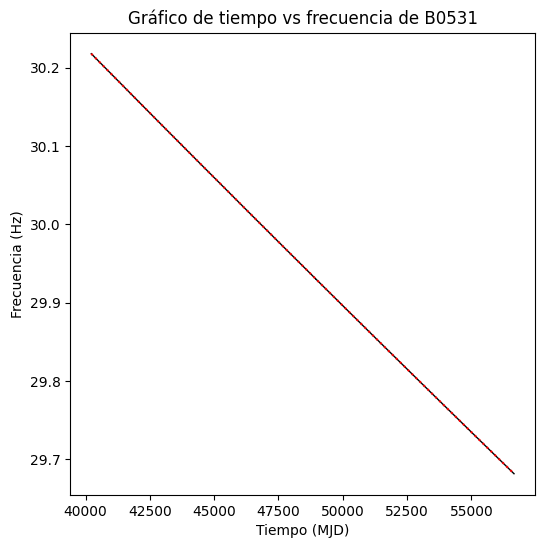

In [8]:
#Para B0531 hay que ajustar la frecuencia con una parábola, la regresión lineal no sirve

arrayTiempoB0531 = np.array(tiempoB0531)
arrayFrecuenciaB0531 = np.array(frecuenciaB0531)

n = len(arrayTiempoB0531)
x = np.sum(arrayTiempoB0531)
x2 = np.sum(arrayTiempoB0531 ** 2)
x3 = np.sum(arrayTiempoB0531 ** 3)
x4 = np.sum(arrayTiempoB0531 ** 4)
y = np.sum(arrayFrecuenciaB0531)
y2 = np.sum(arrayFrecuenciaB0531 ** 2)
y3 = np.sum(arrayFrecuenciaB0531 ** 3)
xy = np.sum(arrayTiempoB0531 * arrayFrecuenciaB0531)
x2y = np.sum((arrayTiempoB0531**2) * arrayFrecuenciaB0531)

matriz = np.array([[n,x,x2],[x,x2,x3],[x2,x3,x4]])
array = np.array([y,xy,x2y])

print(f"Shape of A: {matriz.shape}")
print(f"Shape of b: {array.shape}")

resultados = np.linalg.solve(matriz,array)

a0 = resultados[0]
a1 = resultados [1]
a2 = resultados[2]

# y = a0 + a1*x + a2*(x**2)

linea_tendenciaB0531 = a0 + a1*arrayTiempoB0531 + a2*( arrayTiempoB0531**2 )

glitches_B0531 = arrayFrecuenciaB0531-linea_tendenciaB0531

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(arrayTiempoB0531,glitches_B0531,linewidth=1,color="black",linestyle="--")
plt.show()

# wea = [1,2,3,1] 1
"""
listax = []
for i in range(len(arrayFrecuenciaB0531-2)):
  if arrayFrecuenciaB0531[i]<arrayFrecuenciaB0531[i+1]:
      listax.append(arrayFrecuenciaB0531[i+1])

listax2 = []
for i in range(len(arrayFrecuenciaB0531)):
  if arrayFrecuenciaB0531[-i]<arrayFrecuenciaB0531[-i-1]:
    listax2.append(arrayFrecuenciaB0531[-i])
"""

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0531,frecuenciaB0531,color="black",linewidth=1,)
ax.plot(tiempoB0531, linea_tendenciaB0531,linestyle="dotted",color="red")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()


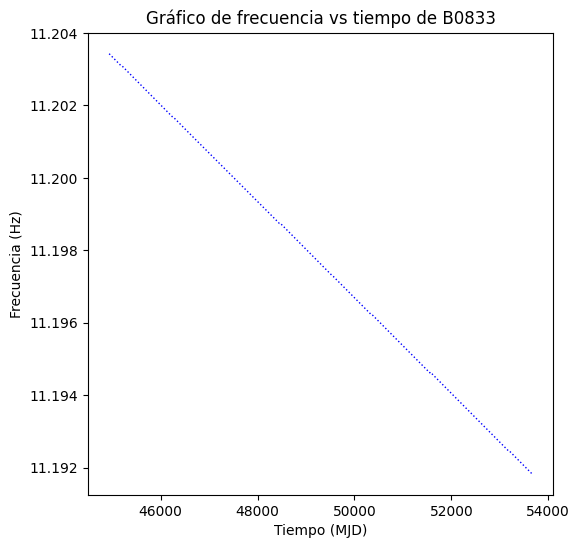

In [ ]:
tiempoB0833 = []
frecuenciaB0833 = []
for i in range(0,len(B0833)-1):
  x = B0833[i].split()
  tiempoB0833.append(float(x[0]))
  frecuenciaB0833.append(float(x[1]))

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0833,frecuenciaB0833,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de frecuencia vs tiempo de B0833")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

La pendiente es: -1.3283125060551748e-06
El intercepto es: 11.263116685094545


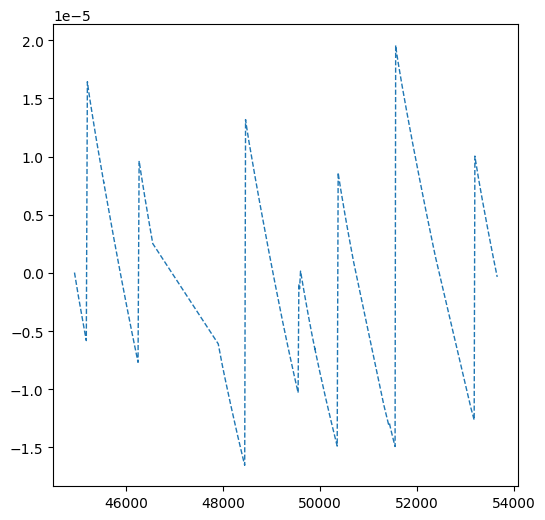

1.644201143768953e-05
1.6236426750637634e-05
1.599876679136969e-05
1.5671026355690287e-05
1.5551114463718818e-05
1.5463606665377938e-05
1.540560894675025e-05
1.5320171714350295e-05
1.5191368337497124e-05
1.4924600353793949e-05
1.4706053759638849e-05
1.460357739091478e-05
1.4524783287228615e-05
1.4428904600904957e-05
1.4315083131322126e-05
1.4121275301093306e-05
1.4020390297631025e-05
1.3824983104981925e-05
1.377011359515734e-05
1.367599907631245e-05
1.3647645692671517e-05
1.2629389582130557e-05
1.2519319364301396e-05
1.2401252936555807e-05
1.2284081263302937e-05
1.2096468630318213e-05
1.1944049946421842e-05
1.1797991474438163e-05
1.1666841935209504e-05
1.1494979599291355e-05
1.1380791402615387e-05
1.1323112207861641e-05
1.1261457842692835e-05
1.0344565565034713e-05
1.0261780746034788e-05
1.0174699715648217e-05
1.0049311979898334e-05
1.0344813563989419e-05
1.0262043746323002e-05
1.0174970714871279e-05
1.0049595980277104e-05
1.3185074235977368e-05
1.3041661407697802e-05
1.287745963374220

In [ ]:
arrayTiempoB0833 = np.array(tiempoB0833)
arrayFrecuenciaB0833 = np.array(frecuenciaB0833)

x = np.sum(arrayTiempoB0833)
y = np.sum(arrayFrecuenciaB0833)
xy = np.sum(arrayFrecuenciaB0833 * arrayTiempoB0833)
x2 = np.sum(arrayTiempoB0833 ** 2)
y2 = np.sum(arrayFrecuenciaB0833 ** 2)
m = (len(tiempoB0833) * xy - x * y) / (len(tiempoB0833) * x2 - (x ** 2))
print(f"La pendiente es: {m}")

b = (y*x2 - x*xy)/(len(tiempoB0833)*x2 - x**2)
print(f"El intercepto es: {b}")

linea_tendencia_B0833 = m*arrayTiempoB0833 + b

glitches_B0833 = arrayFrecuenciaB0833-linea_tendencia_B0833

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(arrayTiempoB0833,glitches_B0833,linewidth=1,linestyle="--")
plt.show()


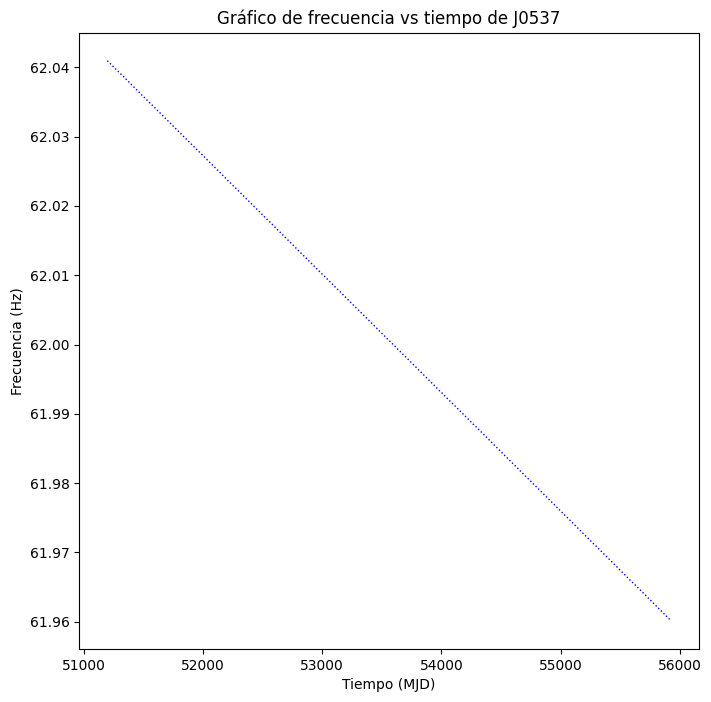

In [ ]:
tiempoJ0537 = []
frecuenciaJ0537 = []
incertezaJ0537 = []
for elem in J0537:
  x = elem.split()
  tiempoJ0537.append(float(x[0]))
  frecuenciaJ0537.append(float(x[1]))
  incertezaJ0537.append(float(x[2]))

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.plot(tiempoJ0537,frecuenciaJ0537,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de frecuencia vs tiempo de J0537")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

La pendiente es: -1.7076871131872296e-05
El intercepto es: 62.915235345105486


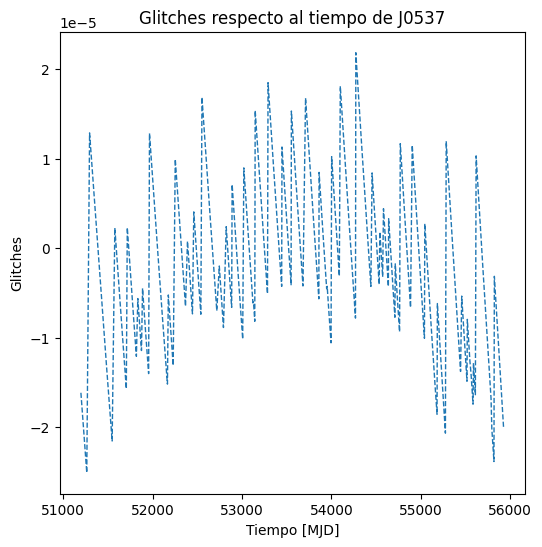

In [ ]:
arrayTiempoJ0537 = np.array(tiempoJ0537)
arrayFrecuenciaJ0537 = np.array(frecuenciaJ0537)

# y = mc + b
# n = 8
# x = semiejeCubo
# y = periodoCuadrado

x = np.sum(arrayTiempoJ0537)
y = np.sum(arrayFrecuenciaJ0537)
xy = np.sum(arrayFrecuenciaJ0537 * arrayTiempoJ0537)
x2 = np.sum(arrayTiempoJ0537 ** 2)
y2 = np.sum(arrayFrecuenciaJ0537 ** 2)
m = (len(tiempoJ0537) * xy - x * y) / (len(tiempoJ0537) * x2 - (x ** 2))
print(f"La pendiente es: {m}")

b = (y*x2 - x*xy)/(len(tiempoJ0537)*x2 - x**2)
print(f"El intercepto es: {b}")

linea_tendencia_J0537 = m*arrayTiempoJ0537 + b

glitches_J0537 = arrayFrecuenciaJ0537-linea_tendencia_J0537

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(arrayTiempoJ0537,glitches_J0537,linewidth=1,linestyle="--")
ax.set_title("Glitches respecto al tiempo de J0537")
ax.set_xlabel("Tiempo [MJD]")
ax.set_ylabel("Glitches")
plt.show()

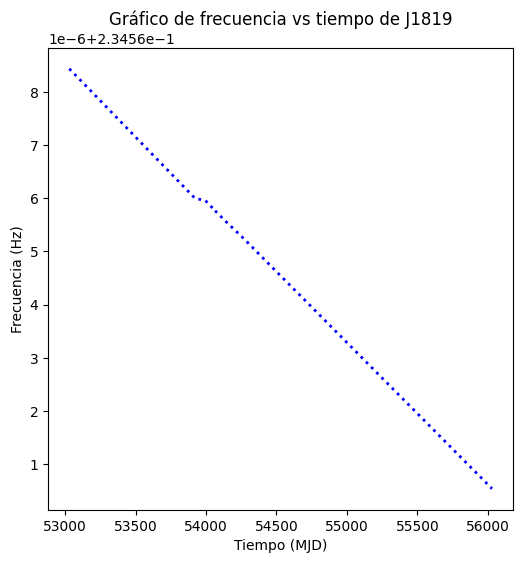

In [ ]:
tiempoJ1819 = []
frecuenciaJ1819 = []
for elem in J1819:
  x = elem.split()
  tiempoJ1819.append(float(x[0]))
  frecuenciaJ1819.append(float(x[1]))

fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ1819,frecuenciaJ1819,color="blue",linewidth=2,linestyle="dotted")
ax.set_title("Gráfico de frecuencia vs tiempo de J1819")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

La pendiente es: -2.625005831333755e-09
El intercepto es: 0.23470765044329833


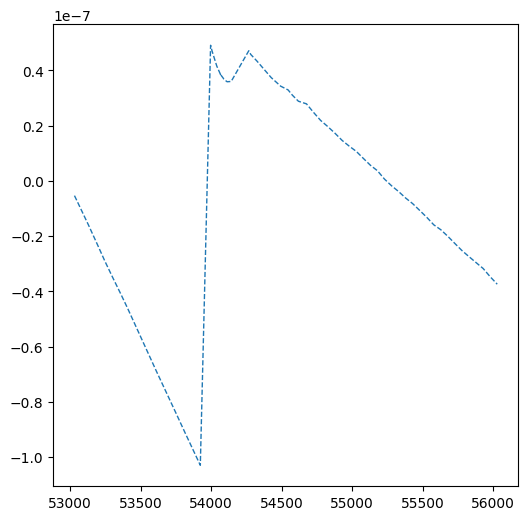

In [ ]:
arrayTiempoJ1819 = np.array(tiempoJ1819)
arrayFrecuenciaJ1819 = np.array(frecuenciaJ1819)

# y = mc + b
# n = 8
# x = semiejeCubo
# y = periodoCuadrado

xP = np.sum(arrayTiempoJ1819)
yP = np.sum(arrayFrecuenciaJ1819)
xyP = np.sum(arrayFrecuenciaJ1819 * arrayTiempoJ1819)
x2P = np.sum(arrayTiempoJ1819 ** 2)
y2P = np.sum(arrayFrecuenciaJ1819 ** 2)
m = (len(tiempoJ1819) * xyP - xP * yP) / (len(tiempoJ1819) * x2P - (xP ** 2))
print(f"La pendiente es: {m}")

b = (yP*x2P - xP*xyP)/(len(tiempoJ1819)*x2P - xP**2)
print(f"El intercepto es: {b}")

linea_tendencia_J1819 = m*arrayTiempoJ1819 + b

glitches_J1819 = arrayFrecuenciaJ1819-linea_tendencia_J1819

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(arrayTiempoJ1819,glitches_J1819,linewidth=1,linestyle="--")
plt.show()